### Paxillin movie segmentation and object feature analysis

with Annabel's 3D fixed image

Liya Ding, 2024.03

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import umap
from joblib import dump, load
import os.path

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.transforms import Bbox

import tifffile 
import czifile

import skimage
from skimage.morphology import remove_small_objects
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb
from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)

from skimage.morphology import binary_opening, binary_dilation
from skimage.morphology import disk


from scipy import ndimage
from scipy.ndimage import distance_transform_cdt
from scipy.ndimage import gaussian_filter

from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# function from aicssegmentation tool
from utils.vessel_2d import filament_2d_wrapper
from utils.pre_processing_utils import intensity_normalization


In [2]:
czimovie_dir =  '/mnt/d/lding/FA/data/FHL2-KI-U2OS-Actin405-Pax568-endoFHL2488_annabel_20240226'

csv_output_dir = '/mnt/d/lding/FA/analysis_results/pax_3D/pax_3D_0226/SM_Vess-LocThr-GlThr-Open_csv'
plot_output_dir = '/mnt/d/lding/FA/analysis_results/pax_3D/pax_3D_0226/SM_Vess-LocThr-GlThr-Open_plot'
seg_output_dir = '/mnt/d/lding/FA/analysis_results/pax_3D/pax_3D_0226/SM_Vess-LocThr-GlThr-Open_seg'

pixel_size = 0.0706
time_point = 0

if not os.path.isdir(csv_output_dir):
    os.makedirs(csv_output_dir)
if not os.path.isdir(plot_output_dir):
    os.makedirs(plot_output_dir)
if not os.path.isdir(seg_output_dir):
    os.makedirs(seg_output_dir)

### for each 3D stack run through MIP and 8th frame

In [19]:
### for each movie, make sub-folders for different output for easier viewing in imagej
movie_mask_output_dir = os.path.join(seg_output_dir,  'cell_mask')

if not os.path.isdir(movie_mask_output_dir):          os.makedirs(movie_mask_output_dir)    

filenames = [x for x in os.listdir(czimovie_dir) if os.path.isfile(os.path.join(czimovie_dir, x)) and ('.czi' in x)]

for filenameID in range(0,len(filenames)):
# for filenameID in range(1): 
    
    filename = filenames[filenameID]
    img = czifile.imread(os.path.join(czimovie_dir,filename))
    actin_img = img[0,0,-1,:,:,:,0].squeeze()
    
    intensity_scaling_param = [10,40]
    norm_actin_img = intensity_normalization(actin_img, scaling_param=intensity_scaling_param)
     
    MIP_actin_img = norm_actin_img.max(axis=0)

    smooth_MIP_actin_img = gaussian_filter(MIP_actin_img,sigma=4,mode='nearest',truncate=3)
    ### low threshold to get cell masks
    new_cell_mask = smooth_MIP_actin_img>0.02
    ### remove isolated small objects (small regions due to noise)
    new_cell_mask = remove_small_objects(new_cell_mask>0, min_size=10000, connectivity=1, in_place=False)        
    # remove holes
    new_cell_mask = ndimage.binary_fill_holes(new_cell_mask)
    label_im, nb_labels = ndimage.label(new_cell_mask)
    sizes = ndimage.sum(new_cell_mask, label_im, range(nb_labels + 1))
    biggest_cell_label = np.argmax(sizes)

    biggest_cell_mask = label_im==biggest_cell_label

    # calculate the distance map   
    biggest_cell_mask = binary_opening(biggest_cell_mask, disk(15))
    
    tifffile.imsave(os.path.join(movie_mask_output_dir, 'annabel0226_cell_mask_'+filename+'_MIP'+'.tif'),(biggest_cell_mask*255).astype(np.uint8))                       

                

In [16]:
sizes

array([     0., 216569., 838700.])

In [17]:
biggest_cell_label


2

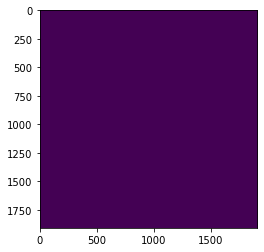

In [18]:
plt.imshow(biggest_cell_mask)


In [5]:
sizes

array([0.])